# Intensity-Time plots

In [132]:
import fabio
import xrdfit
import pathlib
import warnings

from pyFAI.gui import jupyter
import pyFAI.detectors, pyFAI.azimuthalIntegrator
from tqdm.notebook import tqdm

import math
import numpy as np
import matplotlib.pyplot as plt
from xrdfit.spectrum_fitting import FitSpectrum

## Demonstration of creating Intensity-Time plots using pyFAI

This notebook uses the test image found at: http://www.silx.org/pub/pyFAI/testimages/mock.tif
This is clearly an unrealistic scattering image but provides a good way to
demonstrate the method for creating `Intensity-Time` plots.

Load test image from file

<AxesSubplot:title={'center':'Fake diffraction image'}>

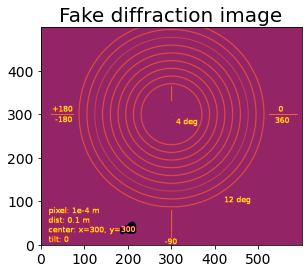

In [133]:
img = fabio.open(r"data/moke.tif").data
jupyter.display(img, label ="Fake diffraction image")

Set up mock detector *- normally you would load a calibration here.*
The parameters are those given with the sample image.

In [134]:
detector = pyFAI.detectors.Detector(pixel1=1e-4, pixel2=1e-4)
ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(dist=0.1, detector=detector)
# Center the detector on the center of the pattern at 300, 300.
ai.setFit2D(100, 300, 300)

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
SampleDetDist= 1.000000e-01m	PONI= 3.000000e-02, 3.000000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 100.000mm	Center: x=300.000, y=300.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

Now rotate the detector. `rot3` is the angle to rotate the detector in the axis of the imaging beam.
See [here](https://pyfai.readthedocs.io/en/latest/usage/tutorial/Geometry/geometry.html#Conclusion) for a
schematic of the detector and rotations.

The minimum cake angle in pyFAI is -180${^\circ}$, and so caking will slice along the horizontal,
rather than being centred on the horizontal. We can centre the cake on the horizontal (and vertical)
by applying a rotation to the detector.

*Note, with 36 cakes and 100 slices the resolution is poor but plotting is fast.
With 360 cakes and 1000 slices it is easier to see image reconstructed from the cakes but plotting is slow.*

In [135]:
num_cakes = 360
num_radial_slices = 1000

# Rotate the detector so that the cardinal direction is in the center of the first cake.
cake_angle = 360 / num_cakes
ai.rot3 = (cake_angle / 2) * (math.pi / 180) # convert rotation to radians

Display the caked image in a flat 2D perspective.

<AxesSubplot:title={'center':'2D regrouping'}, xlabel='Scattering angle $2\\theta$ ($^{o}$)', ylabel='Azimuthal angle $\\chi$ ($^{o}$)'>

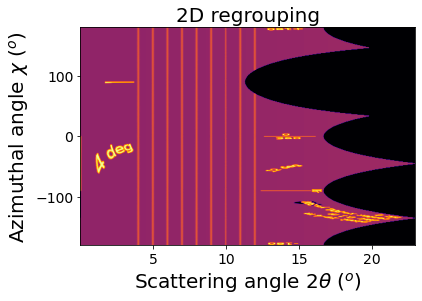

In [136]:
res2d = ai.integrate2d(img, num_radial_slices, num_cakes, unit="2th_deg")
jupyter.plot2d(res2d, label="moke")

We can access the arrays of intensity, radial (2${\theta}$) and azimuthal (${\chi}$) data.

In [137]:
result_intensity = res2d.intensity 
result_radial = res2d.radial
result_azimuthal = res2d.azimuthal
two_theta = res2d.unit
print("unit type is ",two_theta)

unit type is  2th_deg


We can replot the same image as above using the `imshow` function.

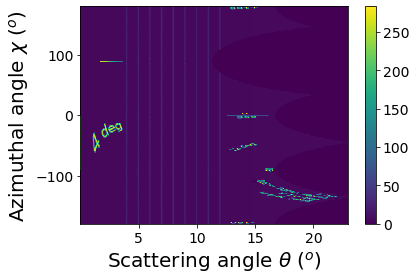

In [138]:
plt.imshow(result_intensity,
           origin='lower',
           extent=[result_radial.min(), 
                   result_radial.max(), 
                   result_azimuthal.min(), 
                   result_azimuthal.max()],
           cmap='viridis',
           interpolation='none',
           aspect='auto')

plt.colorbar()
plt.xlabel(r"Scattering angle ${\theta}$ ($^{o}$)")   
plt.ylabel(r"Azimuthal angle ${\chi}$ ($^{o}$)");

To slice a radial (2${\theta}$) section of the map we can use the function below to return the array index.

In [139]:
def find_nearest(array, value):
    array = np.asarray(array)
    index = (np.abs(array - value)).argmin()
    return array[index], index

We can then use our 2${\theta}$ input to slice a region or diffraction ring of interest.

In [145]:
# user inputs
two_theta_min = 2
two_theta_max = 3

two_theta_min_value, two_theta_min_index = find_nearest(result_radial, two_theta_min)
print("The closest two-theta value = ", two_theta_min_value, ", with index = ", two_theta_min_index)

two_theta_max_value, two_theta_max_index = find_nearest(result_radial, two_theta_max)
print("The closest two-theta value = ", two_theta_max_value, ", with index = ", two_theta_max_index)

result_intensity_cropped = result_intensity[:,two_theta_min_index:two_theta_max_index]
result_radial_cropped = result_radial[two_theta_min_index:two_theta_max_index]

The closest two-theta value =  1.9886151585336096 , with index =  86
The closest two-theta value =  3.0001650657645786 , with index =  130


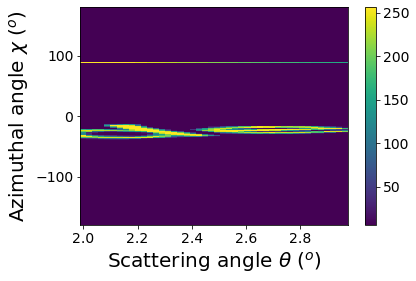

In [146]:
plt.imshow(result_intensity_cropped,
           origin='lower',
           extent=[result_radial_cropped.min(), 
                   result_radial_cropped.max(), 
                   result_azimuthal.min(), 
                   result_azimuthal.max()],
           cmap='viridis',
           interpolation='none',
           aspect='auto')

plt.colorbar()
plt.xlabel(r"Scattering angle ${\theta}$ ($^{o}$)")   
plt.ylabel(r"Azimuthal angle ${\chi}$ ($^{o}$)");

Next, we sum up the intensity for each azimuthal angle (${\chi}$) bin. This is only one image, but when we do this over lots of images we can then trace the changes in azimuthal angle and intensity of the peaks over time, and colour the intensity, to make an `Intensity-Time` plot.

In [147]:
result_intensity_sum = result_intensity_cropped.sum(axis=1)

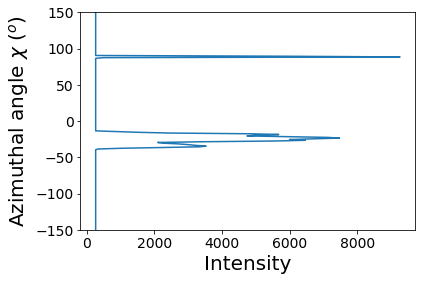

In [148]:
plt.plot(result_intensity_sum,result_azimuthal)
plt.ylim(-150, 150);
plt.xlabel(r"Intensity")   
plt.ylabel(r"Azimuthal angle ${\chi}$ ($^{o}$)");

## Create calibration using pyFAI

In [265]:
import inspect
import time
import pyFAI
from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import CALIBRANT_FACTORY
from pyFAI.goniometer import SingleGeometry

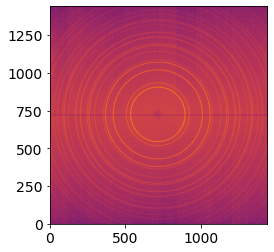

In [266]:
# In this example, we will re-use one of the image used int the test-suite
filename = "calibration/DLS_CeO2_1200mm.tif"
frame = fabio.open(filename).data
# and now display the image
ax = jupyter.display(frame)

In [267]:
# This allow to measure approximatively the position of the beam center ...
x = 712.136 # x-coordinate of the beam-center in pixels
# y = 716.184 # y-coordinate of the beam-center in pixels
# x = 724.816 # x-coordinate of the beam-center in pixels
y = 727.864 # y-coordinate of the beam-center in pixels
d = 1194.046 # This is the distance in mm (unit used by Fit2d)
wl = 1.393000e-11 # The wavelength is 1 Å

In [268]:
# Definition of the detector and of the calibrant:
# pilatus = pyFAI.detector_factory("Pilatus1M")
pilatus = pyFAI.detectors.Detector(pixel1=0.000296, pixel2=0.000296)
print(pilatus)
behenate = CALIBRANT_FACTORY("CeO2")
behenate.wavelength = wl
behenate

Detector Detector	 Spline= None	 PixelSize= 2.960e-04, 2.960e-04 m


CeO2 Calibrant with 41 reflections at wavelength 1.393e-11

In [269]:
pyFAI.detectors.Detector()

Undefined detector

In [253]:
# Set the guessed geometry
initial = pyFAI.geometry.Geometry(detector=pilatus, wavelength=wl)
initial.setFit2D(d,x,y)
initial

Detector Detector	 Spline= None	 PixelSize= 2.960e-04, 2.960e-04 m
Wavelength= 1.393000e-11m
SampleDetDist= 1.194046e+00m	PONI= 2.154477e-01, 2.107923e-01m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1194.046mm	Center: x=712.136, y=727.864 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

In [254]:
# The SingleGeometry object (from goniometer) allows to extract automatically ring and calibrate
sg = SingleGeometry("demo", frame, calibrant=behenate, detector=pilatus, geometry=initial)
sg.extract_cp(max_rings=5)

ControlPoints instance containing 5 group of point:
CeO2 Calibrant with 41 reflections at wavelength 1.393e-11
Containing 5 groups of points:
#ay ring 0: 311 points
#az ring 1: 361 points
#ba ring 2: 361 points
#bb ring 3: 361 points
#bc ring 4: 361 points

<AxesSubplot:title={'center':'demo'}>

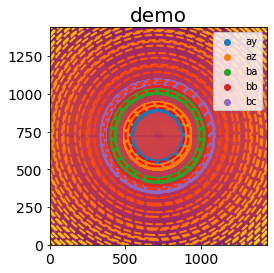

In [257]:
#Control point and rings do not overlap well initially (this was a guessed geometry)
jupyter.display(sg=sg)

In [258]:
# Refine the geometry ... here in SAXS geometry, the rotation is fixed in orthogonal setup
sg.geometry_refinement.refine2(fix=["rot1", "rot2", "rot3", "wavelength"])
sg.get_ai()

TypeError: __init__() got an unexpected keyword argument 'max_shape'

<AxesSubplot:title={'center':'demo'}>

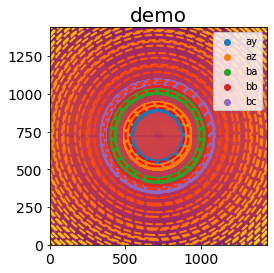

In [259]:
jupyter.display(sg=sg)

In [260]:
#Save the geometry obtained
sg.geometry_refinement.save("calibration/DLS_CeO2_1200mm_pyFAI.poni")
with open("calibration/DLS_CeO2_1200mm_pyFAI.poni") as f:
    print(f.read())

# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Fri Nov 13 11:02:05 2020
poni_version: 2
Detector: Detector
Detector_config: {"pixel1": 0.000296, "pixel2": 0.000296, "max_shape": null}
Distance: 1.1940460000000002
Poni1: 0.215447744
Poni2: 0.21079225599999998
Rot1: 0.0
Rot2: 0.0
Rot3: 0
Wavelength: 1.393e-11



## Plot intensity changes over time

This notebook uses real data and creates an `Intensity-Time` plot for a single lattice plane.

Load calibration image.

In [270]:
ai = pyFAI.load("calibration/DLS_CeO2_1200mm.poni")
# Rotate the detector so that the cardinal direction is in the center of the first cake.
cake_angle = 360 / number_of_cakes
ai.rot3 = (cake_angle / 2) * (math.pi / 180) # convert rotation to radians
print("\nIntegrator: \n", ai)


Integrator: 
 Detector Detector	 Spline= None	 PixelSize= 2.960e-04, 2.960e-04 m
Wavelength= 1.393000e-11m
SampleDetDist= 1.194046e+00m	PONI= 2.114663e-01, 2.067728e-01m	rot1=-0.003366  rot2= 0.000439  rot3= 0.000087 rad
DirectBeamDist= 1194.053mm	Center: x=712.136, y=716.184 pix	Tilt=0.195 deg  tiltPlanRotation= 7.430 deg


In [271]:
def plot_single_slice(ai, input_file: str, two_theta_min: int, two_theta_max: int, 
                      number_of_points: int = 1000, number_of_cakes: int = 36000):
    
    """ Plot an azimuthal angle versus two-theta slice from a diffraction pattern image.
    
    :param input_file: input file name of the diffraction pattern image.
    :param two_theta_min: minimum two-theta value for the slicing of the data.
    :param two_theta_max: maximum two-theta value for the slicing of the data
    :param number_of_points: number of radial points in two-theta (default is 1000).
    :param number_of_cakes: number of azimuthal points in chi, default gives 0.01 degree resolution (default is 36000).
    
    :return: numpy array containing the azimuthal angles, and the intensity values for each time increment.
    """ 
    
    image = fabio.open(input_file).data
    
    result = ai.integrate2d(image, number_of_points, number_of_cakes, unit="2th_deg")
    
    result_intensity = result.intensity 
    result_radial = result.radial
    result_azimuthal = result.azimuthal
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    
    image1 = ax1.imshow(result_intensity,
               origin='lower',
               extent=[result_radial.min(), 
                       result_radial.max(), 
                       result_azimuthal.min(), 
                       result_azimuthal.max()],
               cmap='viridis',
               interpolation='none',
               aspect='auto',
               vmax = 100)
#     plt.colorbar(image1)
#     plt.xlabel(r"Scattering angle ${\theta}$ ($^{o}$)")   
#     plt.ylabel(r"Azimuthal angle ${\chi}$ ($^{o}$)");

    two_theta_min_value, two_theta_min_index = find_nearest(result_radial, two_theta_min)
    print("The closest two-theta value = ", two_theta_min_value, ", with index = ", two_theta_min_index)

    two_theta_max_value, two_theta_max_index = find_nearest(result_radial, two_theta_max)
    print("The closest two-theta value = ", two_theta_max_value, ", with index = ", two_theta_max_index)

    result_intensity_cropped = result_intensity[:,two_theta_min_index:two_theta_max_index]
    result_radial_cropped = result_radial[two_theta_min_index:two_theta_max_index]
    
    image2 = ax2.imshow(result_intensity_cropped,
               origin='lower',
               extent=[result_radial_cropped.min(), 
                       result_radial_cropped.max(), 
                       result_azimuthal.min(), 
                       result_azimuthal.max()],
               cmap='viridis',
               interpolation='none',
               aspect='auto',
               vmax = 100)
#     plt.colorbar(image2)
#     plt.xlabel(r"Scattering angle ${\theta}$ ($^{o}$)")   
#     plt.ylabel(r"Azimuthal angle ${\chi}$ ($^{o}$)");

In [272]:
def find_nearest(array, value):
    array = np.asarray(array)
    index = (np.abs(array - value)).argmin()
    return array[index], index

The closest two-theta value =  2.993529289143804 , with index =  209
The closest two-theta value =  4.0069408245377485 , with index =  280


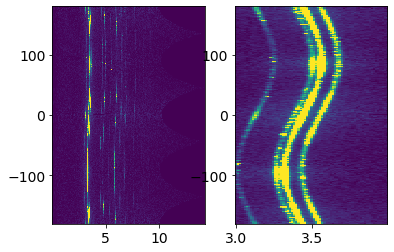

In [273]:
# user inputs
input_file = "data/MAUD/pixium_03100.tif"
two_theta_min = 3
two_theta_max = 4
number_of_points = 1000 # 10000 runs slow, so try 1000
number_of_cakes = 36000 # 36000 gives 0.01 degree resolution for azimuthal changes

plot_single_slice(ai, input_file, two_theta_min, two_theta_max, number_of_points, number_of_cakes)

Use the following function to save the intensity changes with time for a specific lattice plane.

In [12]:
def get_intensity_time(ai, input_filepath: str, output_filepath:str, lattice_plane: str, two_theta_min: int, 
                       two_theta_max: int, number_of_points: int = 1000, number_of_cakes = 36000): 
    
    """ Get the intensity data around a ring for a given two-theta slice from a set of diffraction pattern 
    images, and save as a text file.
    
    :param ai: pyFAI detector calibration.
    :param input_filepath: input filepath containing the diffraction pattern images.
    :param output_filepath: output filepath for saving the analysis text file.
    :param lattice_plane: hkil or hkl indices of the lattice plane.
    :param two_theta_min: minimum two-theta value for the slicing of the data.
    :param two_theta_max: maximum two-theta value for the slicing of the data
    :param number_of_points: number of radial points in two-theta (default is 1000).
    :param number_of_cakes: number of azimuthal points in chi, default gives 0.01 degree resolution (default is 36000).
    
    :return: numpy array containing the azimuthal angles, and the intensity values for each time increment.
    """ 
    # Get a list of the files
    image_list = sorted(pathlib.Path(input_filepath).glob("pixium*"))

    start = True

    for image_path in tqdm(image_list):

        # create an image array and cake the data
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            image = fabio.open(image_path)
        pattern_image_array = image.data
        result2d = ai.integrate2d(pattern_image_array,
                                  number_of_points,
                                  number_of_cakes,
                                  unit="2th_deg",
                                  polarization_factor=0.99,
                                  method='full_csr')
        # get the caked results
        result_intensity = result2d.intensity 
        result_radial = result2d.radial
        result_azimuthal = result2d.azimuthal
        # Slice around a ring using the two-theta min and max values
        two_theta_min_value, two_theta_min_index = find_nearest(result_radial, two_theta_min)
        two_theta_max_value, two_theta_max_index = find_nearest(result_radial, two_theta_max)
        result_intensity_sum = result_intensity[:,two_theta_min_index:two_theta_max_index].sum(axis=1)

        if start:
            # create an empty array to store the results
            result_array = np.array([result_azimuthal,result_intensity_sum])
            start = False

        else:
            # stack the results in the array
            result_array = np.vstack((result_array,result_intensity_sum))

    # write out the data to a text file
    result_array = np.transpose(result_array)
    np.savetxt(f"{output_filepath}intensity_time_{lattice_plane}.txt", result_array)

    return (result_array)

In [14]:
# user inputs
input_filepath = "data/MAUD/"
output_filepath = "analysis/"
lattice_plane = "(10-10)"
two_theta_min = 2
two_theta_max = 3
number_of_points = 1000 # 10000 runs slow, so try 1000
number_of_cakes = 36000 # 36000 gives 0.01 degree resolution for azimuthal changes

result_array = get_intensity_time(ai, input_filepath, output_filepath, lattice_plane, two_theta_min, 
                                  two_theta_max, number_of_points, number_of_cakes)

The result array contains the azimuthal values in the first column, and the intensity values with time, in the subsequent columns.

In [15]:
intensity_array = result_array[:,1:]
azimuthal_array = result_array[:,0]
time = np.arange(0,np.size(intensity_array,1))

We can now plot the intensity changes for a single lattice plane with time.

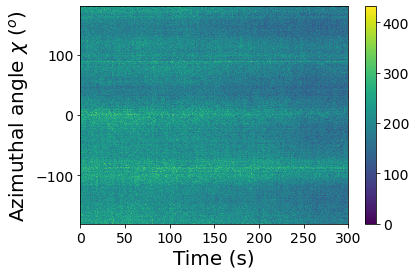

In [19]:
plt.imshow(intensity_array,
           origin='lower',
           extent=[time.min(), 
                   time.max(), 
                   azimuthal_array.min(), 
                   azimuthal_array.max()],
           cmap='viridis',
           interpolation='none',
           aspect='auto')

plt.colorbar()
plt.xlabel(r"Time (s)")   
plt.ylabel(r"Azimuthal angle ${\chi}$ ($^{o}$)");

## Plot intensity changes over time for different lattice planes